In [ ]:
pip install -U --quiet langchain_google_genai langgraph langchain

In [ ]:
pip install langchain-google-genai

In [3]:
from typing import TypedDict
from langgraph.graph import StateGraph, END
import google.generativeai as gena
from google.colab import userdata
from langchain_core.prompts import ChatPromptTemplate
import os
import google.generativeai as genai
from langchain_google_genai import GoogleGenerativeAI
import re

GEMINI_API_KEY = userdata.get("GEMINI_API_KEY")

genai.configure(api_key=GEMINI_API_KEY)

model = genai.GenerativeModel("gemini-1.5-flash")

llm = GoogleGenerativeAI(google_api_key=GEMINI_API_KEY, model="gemini-1.5-flash")
print(llm)

GoogleGenerativeAI
Params: {'model': 'gemini-1.5-flash', 'temperature': 0.7, 'top_p': None, 'top_k': None, 'max_output_tokens': None, 'candidate_count': 1}


In [4]:
class STATE(TypedDict):
    """Represents the state of the essay grading process."""
    essay: str
    relevence_score: float
    grammar_score: float
    fluency_score: float
    overall_score: float
    suggested_edits: str
    topic: str

In [8]:
def get_score(content: str) -> float:
    """Extract the numeric score from the LLM's response."""
    match = re.search(r'Score:\s*(\d+(\.\d+)?)', content)
    if match:
        return float(match.group(1))
    else:
      print(f"Warning: Could not extract score from response: {content}")
      return 0

def check_relevance(state: STATE) -> STATE:
    """Check the relevance of the essay."""
    prompt = ChatPromptTemplate.from_template(
        "Analyze the relevance of the following essay to the given topic."
        "Provide a relevance score between 0 and 4, if essay is completely off topic do not exceed the score by 1"
        "Your response should start with 'Score: ' followed by the numeric score, "
        "then provide your explanation.\n\nTopic: {topic}\nEssay: {essay}"
    )
    prompt_string = prompt.format_prompt(essay=state["essay"], topic=state["topic"]).to_string()
    response = llm(prompt_string) # Pass the string prompt to the llm
    state["relevence_score"] = get_score(response)
    return state

def check_grammar(state: STATE) -> STATE:
    """Check the grammar of the essay."""
    prompt = ChatPromptTemplate.from_template(
        "Analyze the grammar of the following essay."
        "Provide a grammar score between 0 and 3"
        "Your response should start with 'Score: ' followed by the numeric score, "
        "then provide your explanation.\n\nEssay: {essay}"
    )
    prompt_string = prompt.format_prompt(essay=state["essay"]).to_string()
    response = llm(prompt_string) # Pass the string prompt to the llm
    state["grammar_score"] = get_score(response)
    return state

def check_fluency(state: STATE) -> STATE:
    """Check the fluency of the essay."""
    prompt = ChatPromptTemplate.from_template(
        "Analyze the fluency of the following essay. "
        "Provide a fluency score between 0 and 3"
        "Your response should start with 'Score: ' followed by the numeric score, "
        "then provide your explanation.\n\nEssay: {essay}"
    )
    prompt_string = prompt.format_prompt(essay=state["essay"]).to_string()
    response = llm(prompt_string) # Pass the string prompt to the llm
    state["fluency_score"] = get_score(response)
    return state

def suggest_edits(state: STATE) -> STATE:
    """Suggest edits to the essay."""
    essay = state["essay"]
    relevence_score  = state["relevence_score"]
    grammar_score = state["grammar_score"]
    fluency_score = state["fluency_score"]
    topic = state["topic"]
    prompt = ChatPromptTemplate.from_template(
        "You are an expert essay grader. check the scores and suggest changes in the following essay to improve the score. \n\n relevance_score: {relevance_score}\n grammar_score: {grammar_score}\n fluency_score: {fluency_score}\n"
        "check the topic and match it with the essay and check for improvements in the relevance if the essay is completely off topic and doesn't seem to be related to the topic, simply inform the user that the essay seems to be completely off topic and needs to be rewritten from ground zero"
        "Your response should start with reviewing the Score: provide your explanation why the essay was scored the way it is scored?"
        "Please provide suggestions to improve the overall quality of the following essay:\n\n"
        "Focus on clarity, Relevnce, grammar, and structure."
        "Provide specific edits or suggestions for improvement, focusing on the most impactful changes.\n\n Topic: {topic}\nEssay: {essay} \n\n"
    )
    prompt_string = prompt.format_prompt(relevance_score=relevence_score, grammar_score=grammar_score, fluency_score=fluency_score, essay=essay, topic=topic).to_string()
    response = llm(prompt_string)
    state["suggested_edits"] = response
    return state

def grade_essay(state: STATE) -> STATE:
    """Grade the essay."""
    state = suggest_edits(state)
    state['overall_score'] = (state['relevence_score'] + state['grammar_score'] + state['fluency_score'])
    return state

In [9]:
# Initialize the StateGraph
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from typing import Literal
workflow = StateGraph(STATE)

workflow.set_entry_point("check_relevance")
workflow.add_node("check_relevance", check_relevance)
workflow.add_node("check_grammar", check_grammar)
workflow.add_node("check_fluency", check_fluency)
workflow.add_node("grade_essay", grade_essay)


# Define the flow based on scores
def decide_relevancy(essay: STATE) -> Literal["check_grammar","grade_essay"]:
  if essay['relevence_score']>1:
    return "check_grammar"
  else:
    return "grade_essay"

def decide_grammar(essay: STATE) -> Literal["check_fluency","grade_essay"]:
   if essay['grammar_score']>1:
      return "check_fluency"
   else:
        return "grade_essay"

def decide_fluency(essay: STATE) -> Literal["grade_essay"]:
  if essay['fluency_score']>1:
    return "grade_essay"
  else:
    return "grade_essay"

workflow.add_conditional_edges("check_relevance", decide_relevancy)
workflow.add_conditional_edges("check_grammar", decide_grammar)
workflow.add_edge("check_fluency", "grade_essay")
workflow.add_edge("grade_essay", END)

# Compile the graph
graph = workflow.compile()


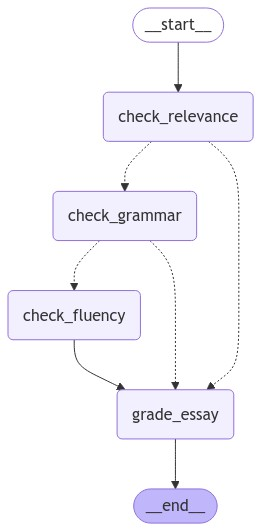

In [10]:
import time

def get_Grade(topic:str, content: str) -> float:
    """Grade the given essay using the defined workflow."""
    time.sleep(1)
    initial_state = dict(
        essay=content,
        relevence_score=0.0,
        grammar_score=0.0,
        fluency_score=0.0,
        overall_score=0.0,
        suggested_edits="",
        topic=topic,
    )
    result = graph.invoke(initial_state)
    return result

display(Image(graph.get_graph().draw_mermaid_png()))

In [13]:
result = get_Grade(input("Enter The Topic: "), input("Enter Your Essay: "))
# Display the results
print(f"Relevance Score: {result['relevence_score']:.1f}/4")
print(f"Grammar Score: {result['grammar_score']:.1f}/3")
print(f"Structure Score: {result['fluency_score']:.1f}/3\n")
print(f"Final Essay Score: {result['overall_score']:.1f}/10\n\n")
print(f"--Suggested Improvements: {result['suggested_edits']}")

Enter The Topic: Terrorism in pakistan
Enter Your Essay: Tourism in Pakistan: A Hidden Gem Tourism plays a pivotal role in the economic development of countries around the world. In Pakistan, a country endowed with rich cultural heritage, diverse landscapes, and historical significance, tourism has immense potential yet remains largely underexplored. This essay delves into the various aspects of tourism in Pakistan, including its attractions, challenges, and prospects for growth.  Attractions Pakistan is home to some of the most breathtaking landscapes on the planet. From the towering peaks of the Himalayas and Karakoram ranges, including K2, the second-highest mountain in the world, to the serene beaches of Karachi, the country offers a plethora of natural wonders. The northern regions, such as Gilgit-Baltistan and Swat, are particularly popular among adventure seekers and nature lovers. These areas provide opportunities for trekking, hiking, and mountaineering, attracting both local 